# Lab 05: Wine Quality

---
author: Jakub Szumny
date: October 5, 2024
embed-resources: true
---

## Introduction

Wine is a very popular alcoholic beverage, made from fermented fruit. Working for a startup that wants to create an AI Sommelier, a professional that specializes in wine services. Instead of using a trained human, I will purchase chemistry equipment to generate data for wines, and train a model based on previous wine quality created by human sommeliers. I will be creating a model that predicts a wine's quality given its physicochemical characteristics.

## Methods

In [2]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning
from sklearn.datasets import make_friedman1
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor

### Data

In [3]:
# load data
wine_train = pd.read_csv(
    "https://cs307.org/lab-05/data/wine-train.csv",
)
wine_test = pd.read_csv(
    "https://cs307.org/lab-05/data/wine-test.csv",
)
wine_train


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.6,0.23,0.64,12.9,0.033,54.0,170.0,0.99800,3.00,0.53,8.8,5,white
1,NaN,0.75,0.01,2.2,0.059,11.0,18.0,0.99242,3.39,0.40,NaN,6,red
2,7.4,0.67,0.12,1.6,0.186,5.0,21.0,0.99600,3.39,0.54,9.5,5,red
3,6.4,0.18,0.74,NaN,0.046,54.0,168.0,0.99780,3.58,0.68,10.1,5,white
4,6.7,0.35,0.32,9.0,0.032,29.0,113.0,0.99188,3.13,0.65,12.9,7,white
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4152,6.6,0.32,0.22,16.7,0.046,38.0,133.0,0.99790,3.22,0.67,10.4,6,white
4153,9.2,0.58,0.20,3.0,0.081,15.0,115.0,0.99800,3.23,0.59,9.5,5,red
4154,8.2,0.60,0.17,2.3,0.072,11.0,73.0,0.99630,3.20,0.45,9.3,5,red
4155,6.5,0.23,0.36,16.3,0.038,43.0,133.0,0.99924,3.26,0.41,8.8,5,white


The wine quality data is from the paper, "Modeling wine preferences by data mining from physicochemical properties", and the data from this paper became a standard dataset in the ML community and is available via the UC Irvine Machine Learning Repository. The data contains two seperate datasets, one for red wine and one for white, but we have a combined dataset of both, including a column for the color of the wine, and the data has been additionally modified.

The dataset includes: 
## Response

- **quality** `[int64]`:  
  The quality of the wine based on evaluation by a minimum of three sensory assessors (using blind tastes), which graded the wine on a scale ranging from 0 (very bad) to 10 (excellent).

## Features

- **color** `[object]`:  
  The (human perceivable) color of the wine, either red or white.

- **fixed acidity** `[float64]`:  
  Grams of tartaric acid per cubic decimeter.

- **volatile acidity** `[float64]`:  
  Grams of acetic acid per cubic decimeter.

- **citric acid** `[float64]`:  
  Grams of citric acid per cubic decimeter.

- **residual sugar** `[float64]`:  
  Grams of residual sugar per cubic decimeter.

- **chlorides** `[float64]`:  
  Grams of sodium chloride per cubic decimeter.

- **free sulfur dioxide** `[float64]`:  
  Milligrams of free sulfur dioxide per cubic decimeter.

- **total sulfur dioxide** `[float64]`:  
  Milligrams of total sulfur dioxide per cubic decimeter.

- **density** `[float64]`:  
  The total density of the wine in grams per cubic centimeter.

- **pH** `[float64]`:  
  The acidity of the wine, measured using pH.

- **sulphates** `[float64]`:  
  Grams of potassium sulphate per cubic decimeter.

- **alcohol** `[float64]`:  
  Percent alcohol by volume.


In [4]:
# summary statistics

print("Num of Samples: ", len(wine_train))
print("Num of Features: ", wine_train.shape[1] - 1)

Num of Samples:  4157
Num of Features:  12


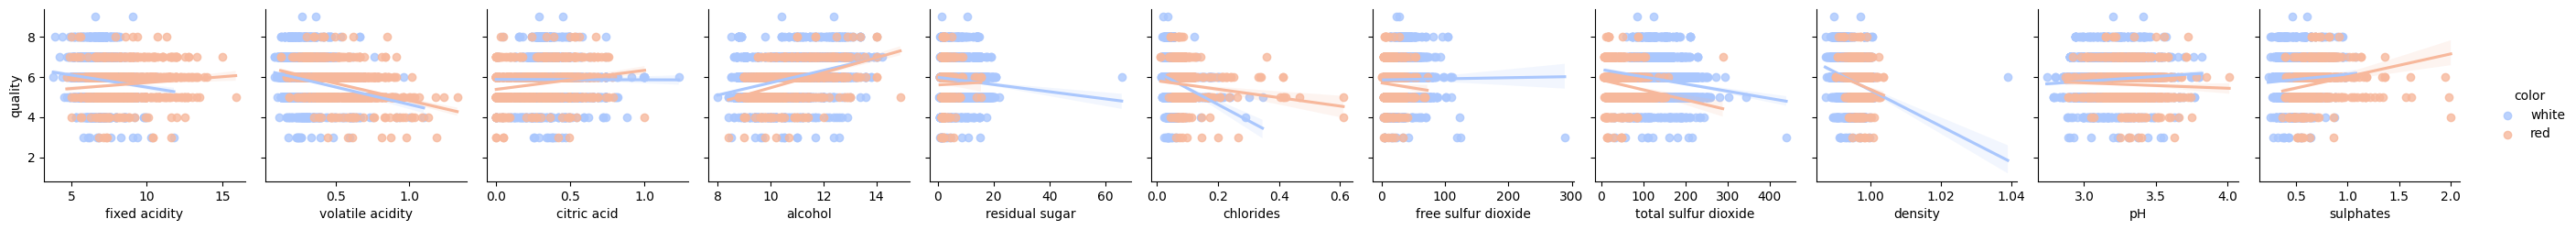

In [18]:
# visualizations
x_vars = ['fixed acidity', 'volatile acidity', 'citric acid', 'alcohol', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates']

sns.pairplot(wine_train, diag_kind='kde', kind='reg', y_vars='quality', x_vars = x_vars, hue='color', palette='coolwarm')


Based off of the visualization we can see the different correlations of each feature with the quality of the wines, white or red. If you look closely, you can see that some qualities increase as the variables increase, and some also decrease as the variables increase. Things like volatile acidity, resiudal sugar, chlorides, and density, shows a strong decrease in quality as they increase. Others like citric acid, alcohol, sulphates, show a strong increase in quality as they increase. From this we can see and make assumptions based on the quality of the wine based off of just these variables. This is a good sign, as most of the features show a good correlation with the response variable, which will help train the model much better, and be more accurate.

### Models

In [6]:
# process data for ML
# create X and y for train
X_train = wine_train.drop("quality", axis=1)
y_train = wine_train["quality"]

# create X and y for test
X_test = wine_test.drop("quality", axis=1)
y_test = wine_test["quality"]

In [19]:
# train models

categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_features = X_train.select_dtypes(include=['int', 'float']).columns.tolist()

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder()),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        # ("regressor", KNeighborsRegressor()),
        ("regressor", RandomForestRegressor())
    ]
)

param_grid = {
    "preprocessor__cat__onehot__drop": [None, "first"],
    "preprocessor__num__scaler": [None, StandardScaler()],
    "regressor__n_estimators": [100, 200],
    "regressor__max_depth": [None, 10, 20]
    
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="neg_mean_absolute_error")
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation RMSE: {grid_search.best_score_}")

y_pred = grid_search.predict(X_test)

from sklearn.metrics import mean_absolute_error

print(f"Test set MAE: {mean_absolute_error(y_test, y_pred)}")

Best parameters: {'preprocessor__cat__onehot__drop': 'first', 'preprocessor__num__scaler': StandardScaler(), 'regressor__max_depth': None, 'regressor__n_estimators': 200}
Best cross-validation RMSE: -0.48623612364620944
Test set MAE: 0.47589903846153847


Here I used a pipeline and a grid search cross validation to find the best possible parameters for this model, using a Random Forest Regressor. I found that the best depth was None, and the best n esimators was 200 to get the best results. From this I got a .486 cross validation MAE, which is not very good.

In [21]:
from joblib import dump

dump(grid_search, "wine-quality.joblib")

['wine-quality.joblib']

## Results

In [20]:
# report model metrics
print(f"Test set MAE: {mean_absolute_error(y_test, y_pred)}")

Test set MAE: 0.47589903846153847


On the test set, the model recieved a .476 MAE, which is not very good, as almost half of the predictions were errors, on a completely new set of data.

## Discussion

After recieving a test set MAE of .476, I can say that this model is definitely not the best, and probably should not be used for the real life predictions of wine quality. It definitely has the capacity to possibly be refined, as it is not that great of a model.

I think it could be possible for an AI to replace some aspects of a sommelier, but I don't know if it could replace all aspects. I feel like there are some things AI just can't do, and I feel like with wine, there are a lot of senses required to really be able to rate it, not just based on solely the data and the chemistry behind it. So no I don't think the cost of the chemistry equipment and processes are not worth removing humans from this process.

As the quality data given are integers, my predictions are also integers. I used a regression task for this, as it is a rating from 1-10, and could be any possible number in that range. A classification task instead, what be exact numbers, which technically could be done for this task, but I believe a regression technique is best.


### Conclusion

To conclude, given the subpar mean absolute error percentage of .476, I would not reccomend this model for usage in the real world. It definitely is not good enough, to be predicting wine quality in a real life scenario, as it was predict the wine about 47% incorrectly on average. I would say that this model could be improved, by possibly adding some more features, but features which would need to be added by real sommeliers, as I believe there are many things in this case AI can not replicate from a sommelier.